In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import matplotlib.pyplot as plt

import numpy as np
import scipy
import tqdm
import torch 
import torch.nn.functional as func

import dataset
import models
import utils
import train

FAUST = "../../Downloads/Mesh-Datasets/MyFaustDataset"
MODEL_PATH = "../model_data/data.pt"

data = dataset.FaustDataset(FAUST)

model = models.ChebnetClassifier(
    param_conv_layers=[128,128,64,64],
    E_t=data.downscaled_edges, 
    D_t=data.downscale_matrices,
    num_classes = 10)

traindata = data[20:]
evaldata = data[:20]

#train network
train.train(
    train_data=traindata,
    classifier=model,
    param_file=MODEL_PATH,
    epoch_number=0)


#compute accuracy
accuracy, confusion_matrix = train.evaluate(eval_data=evaldata,classifier=model)
print(accuracy)

In [14]:
%load_ext autoreload
%autoreload 2


import os
import pickle
import matplotlib.pyplot as plt

import numpy as np
import scipy
import tqdm
import torch 
import torch.nn.functional as func

import dataset
import models
import utils

FAUST = "../../Downloads/Mesh-Datasets/MyFaustDataset"
MODEL_PATH = "../model_data/data.pt"
data = dataset.FaustAugmented(FAUST)


file = "DistAdversarialGenerator.pt"
file = "SpectralAdversarialGenerator.pt"
file = "EuclideanAdversarialGenerator.pt"
file = "MCFAdversarialGenerator.pt"




with open(file,"rb") as f:
    d = pickle.load(f)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


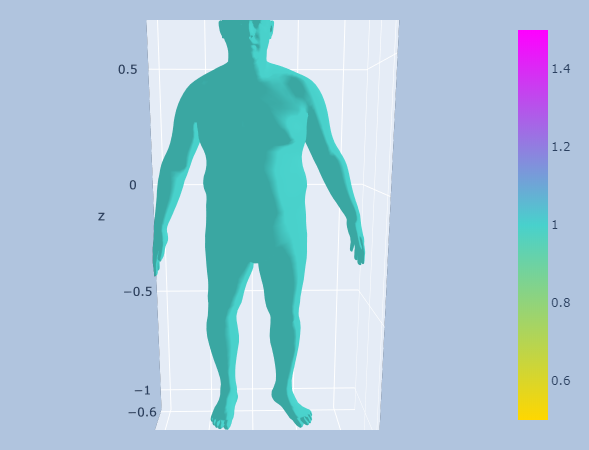

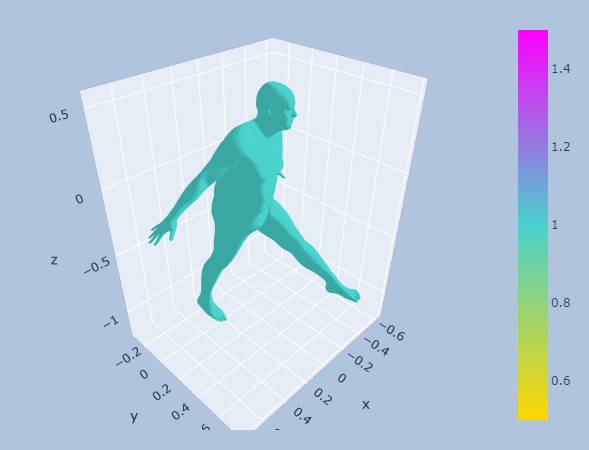

In [17]:
data.transform = lambda x:x
subjidx = 7
poseidx = 0

idx = 200+subjidx*6 + (10-poseidx) if poseidx >= 10 else 100 + subjidx*10 + poseidx
visualize(data[idx].pos, data[0].face.t())


subjidx = 7
poseidx = 4
visualize(data[200+subjidx*6 + poseidx].pos, data[0].face.t())


dict_keys(['model-index', 'target', 'c-value', 'y', 'positions', 'perturbed-positions', 'adversarial-generator', 'tracking-data', 'misclassified', 'ground-truth'])
torch.Size([13780, 3])
torch.Size([27552, 3])


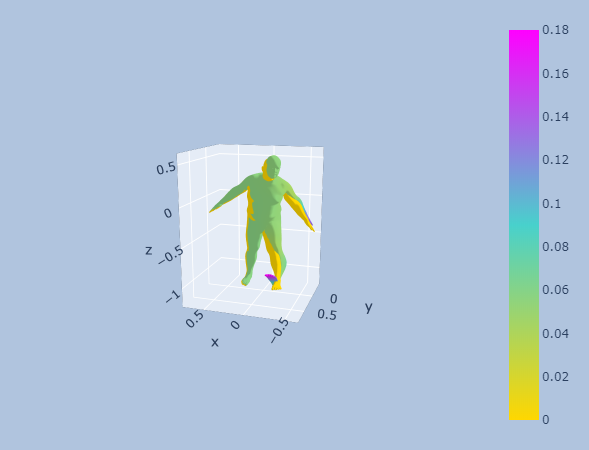

In [76]:
import torch_geometric

print(d[246,0].keys())
positions = torch.tensor(d[246,0]["positions"])
perturbed_position = torch.tensor(d[246,0]["perturbed-positions"])

faces = data[0].face

mesh_normal = torch_geometric.data.Data(pos=positions, face=faces)
mesh_perturbed = torch_geometric.data.Data(pos=perturbed_position, face=faces)

pos = positions
ppos = perturbed_position
N = positions.shape[0]

tmpx = torch.cat([pos, ppos],dim=0)
tmpf = torch.cat([faces.t(), faces.t()+N], dim=0)
color = torch.zeros([N*2],dtype=pos.dtype, device=pos.device)
color[N:] = (pos-ppos).norm(p=2,dim=-1)

print(tmpx.shape)
print(tmpf.shape)
visualize(tmpx,tmpf,color)

import torch_geometric.io
write_obj(mesh_normal, "normal-example.obj")
write_obj(mesh_perturbed, "adversarial-example.obj")
#torch_geometric.io.write_off(data[, "normal-example.off")


In [64]:
def write_obj(mesh, file):
    with open(file, 'w') as f:
        f.write("# OBJ file\n")
        for v in mesh.pos:
            v = v.numpy()
            f.write("v {} {} {}\n".format(v[0], v[1], v[2]))
            
        for face in mesh.face.t():
            f.write("f")
            face = face.numpy()
            for i in face:
                f.write(" %d" % (i + 1))
            f.write("\n")

def read_obj(file):
    vertices = []
    faces = []
    with open(file, 'r') as f:
        line = file.readline()
        fc =  line[0]
        if fc == "#": 
            pass
        elif fc == "v":
            vertices += [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]        
        elif fc == "f":
            faces += [[int(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    vertices = np.array(vertices, dtype=np.float64)
    faces = np.array(faces, dtype=np.long)
    return vertices, faces


In [3]:
import plotly
import plotly.graph_objects as go
import numpy as np

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()


now that we have defined the visualization procedure, we can show some meshes:

In [ ]:
import adversarial.carlini_wagner as cw

i=20
x = data[i].pos
e = data[i].edge_index.t()
f = data[i].face.t()
y = data[i].y
t = 9
n = x.shape[0]
eigs_num = 100


builder = cw.AdversarialExampleBuilder(model).set_log_interval(2)
builder.set_perturbation_type("spectral").set_mesh(x,e,f).set_target(t).set_distortion_functions(cw.LocallyEuclideanDistortion())
adex = builder.set_adversarial_coeff(1e-6).build(50, 8e-4, usetqdm="standard")


In [ ]:
import adversarial.carlini_wagner as cw
visualize(adex.perturbed_pos,adex.faces, torch.norm(adex.perturbed_pos- adex.pos,p=2,dim=-1))
adex.logger.show()

plt.figure()
plt.scatter(range(10), model(adex.pos).detach())
plt.scatter(range(10), model(adex.perturbed_pos).detach())
plt.show()

## Metrics


In [ ]:
def compute_distance_mse(pos, perturbed_pos, faces, K, t):
    eigvals1, eigvecs1 = eigenpairs(pos, faces, K)
    eigvals2, eigvecs2 = eigenpairs(perturbed_pos, faces, K)
    d1 = diffusion_distance(eigvals1,eigvecs1,t)
    d2 = diffusion_distance(eigvals2,eigvecs2,t)
    return d1,d2


def compute_distance_distance(distance, perbed_pos, faces, K, t):
    eigvals, eigvecs = eigenpairs(perbed_pos, faces, K)
    d = diffusion_distance(eigvals,eigvecs,t)
    return torch.nn.functional.mse_loss(distance, d)

def get_generator_data(adv_data, faces, K=10, t=0.01):
    out_dictionary = {"MSE_diffusion":[], "LB_loss":[], "MCF_loss":[], "Euclidean_loss":[]}
    diff_distances, mesh_eigenpairs = {}, {}
    for (idx, target), data in adv_data.items():
        print("processing ", idx,":",target)

        # get useful properties
        metrics = data["tracking-data"]
        pos = torch.tensor(data["positions"],dtype=torch.double)
        ppos = torch.tensor(data["perturbed-positions"],dtype=torch.double)
        c = data["c-value"]
        
        if idx not in mesh_eigenpairs:
            mesh_eigenpairs[idx] = utils.eigenpairs(pos, faces, K)
            
        if idx not in diff_distances:
            diff_distances[idx] = diffusion_distance(*mesh_eigenpairs[idx], t)

        out_dictionary["MSE_diffusion"] = compute_distance_distance(
            diff_distances[idx], ppos, faces, K, t)
        
        # insert metrics into output dictionary  
        for k in out_dictionary.keys():
            if k in metrics: out_dictionary[k].append(metrics[k][-1])

    # convert into numpy arrays
    for k in out_dictionary.keys():out_dictionary[k] = np.array(out_dictionary[k])
    return out_dictionary


root = "../model_data/adv_data"
filenames = ["Spectral", "MCF", "Dist"]
faces = data[0].face.t()

generators_data = {}
for fname in filenames:
  absname = os.path.join(root, fname+"AdversarialGenerator.pt")
  with open(absname, "rb") as f:
    generators_data[fname] = pickle.load(f)
    
processed_data = {}
for gname, adv_data in generators_data.items():
    print(gname)
    processed_data[gname] = get_generator_data(adv_data, faces, K=30, t=0.01)
    

## Plot data

In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

def boxplot(boxdata, labels=[], title="", ylabel="", xlabel="",savefile=None, yscale=None):
    fig = plt.figure(1, figsize=(9, 6))
    ax = plt.subplot(111)
    ax.boxplot(boxdata)
    if yscale is not None: plt.yscale(yscale)
    locs, _ = plt.xticks()
    plt.xticks(locs, labels,fontsize=17)
    plt.xlabel(xlabel,fontsize=20, fontweight='bold')
    plt.ylabel(ylabel,fontsize=20, fontweight='bold')
    plt.suptitle(title,fontsize=25, fontweight='bold')
    if savefile is not None:
        plt.savefig(savefile,dpi=300,bbox_inches='tight')


In [ ]:
def prefix2label(gen_prefix:str):
    pref2lab = {
         "Spectral":"Laplace-\nBeltrami",
         "Dist":"locally\nEuclidean", 
         "Euclidean":"point-wise\nEuclidean", 
         "MCF":"mean\ncurvature"}
    return pref2lab[gen_prefix]

def generate_diffusion_distance_boxplots(root, names_prefixes, ti, yscale="linear"):
    diffusion_data = {}
    for fname in names_prefixes:
      absname = os.path.join(root, fname+"_diff_dist.pt")
      with open(absname, "rb") as f:
        diffusion_data[fname] = pickle.load(f)
    
    boxdata = np.stack([diffusion_data[name][:,ti] for name in names_prefixes], axis=1)
    labels = [prefix2label(prefix) for prefix in names_prefixes]
    xlab = "Distortion Functions"
    ylab = "Diffusion distance mse"
    title = "Diffusion Distance MSE"
    savefile = "../../Dropbox/LaTeX/master-thesis/img/diff_dist_{}.png".format(ti)
    boxplot(boxdata, labels, title, ylab, xlab, savefile, yscale=yscale)

In [ ]:
root = "../model_data/diff_dist"
filenames = ["Spectral", "MCF", "Dist", "Euclidean"]
generate_diffusion_distance_boxplots(root, filenames, ti=2, yscale="log")


In [ ]:
diffusion_data = {}
for fname in filenames:
  absname = os.path.join(root, fname+"_diff_dist.pt")
  with open(absname, "rb") as f:
    diffusion_data[fname] = pickle.load(f)

boxplot(diffusion_data["Euclidean"][1])

In [ ]:
import os
import pickle
import matplotlib.pyplot as plt
from mesh.laplacian import LB_v2

def euclidean_statistics(adv_data):
    out = []
    areas={}
    for (idx, target), data in adv_data.items():
        print("processing ", idx,":",target)
        pos = torch.tensor(data["positions"],dtype=torch.double)
        ppos = torch.tensor(data["perturbed-positions"],dtype=torch.double)
        
        if idx not in areas:
            _, (_, a) = LB_v2(pos, faces)
            areas[idx] = a

        out.append(compute_euclidean(pos,ppos, a).numpy())
    return  np.array(out)

root = "../model_data/adv_data"
filenames = ["Spectral", "MCF", "Dist", "Euclidean"]
faces = data[0].face.t()

generators_data = {}
for fname in filenames:
  absname = os.path.join(root, fname+"AdversarialGenerator.pt")
  with open(absname, "rb") as f:
    generators_data[fname] = pickle.load(f)
    
processed_data = {}
for gname, adv_data in generators_data.items():
    print(gname)
    processed_data[gname] = euclidean_statistics(adv_data)
    

In [ ]:
root = "../model_data/"
savefile = "../../Dropbox/LaTeX/master-thesis/img/gerror.png"
filenames = ["Spectral", "MCF", "Dist", "Euclidean"]

gerror =scipy.io.loadmat(root+"geodesic_error", struct_as_record=False)["geodesic_error_struct"][0,0]
L = np.concatenate([getattr(gerror, attr) for attr in filenames], axis=1)

labels = [prefix2label(prefix) for prefix in filenames]
boxplot(
    boxdata = L/(6890**2),
    labels = labels,
    title = "Geodesic Error",
    ylabel = "mean geodesic error",
    xlabel = "Distortion Functions",
    savefile=savefile)

